In [ ]:
import numpy as np
import argparse
import dlib
import cv2
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import imutils
from imutils import face_utils
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dataset_split.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Shared.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/Shared/shape_predictor_68_face_landmarks.dat')


In [ ]:
def get_data(direc):
    X =[]
    y = []
    IMG_SIZE = 50
    categories = os.listdir(direc)
    for category in categories:
        path_link = os.path.join(direc, category)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image),cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            X.append(image_array)
            y.append(int(category))
    return X,y



In [ ]:
X_train,y_train = get_data("/content/dataset_split/train")
X_test,y_test = get_data("/content/dataset_split/test")

In [ ]:
X_train = np.array(X_train).reshape(-1,50,50,1)
X_test = np.array(X_test).reshape(-1,50,50,1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"

In [ ]:
batch=32

In [ ]:
learning_rate = 0.0001
adam = Adam(lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, #minimium amount of change to count as an improvement
                          patience = 10, # how many epochs to wait before stopping
                          verbose = 1,
                          restore_best_weights = True),
    ReduceLROnPlateau(factor=0.9, patience=10, min_lr=0.0001),
    ModelCheckpoint('NewEyeModel.h5', verbose=1, save_best_only=True)#, save_weights_only=True
]

In [ ]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation="relu", input_shape=X_test.shape[1:]))
model2.add(MaxPooling2D(2, 2))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(64, (3, 3), activation="relu"))
model2.add(Conv2D(64, (3, 3), activation="relu"))
model2.add(MaxPooling2D(2, 2))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(128, (3, 3), activation="relu"))
model2.add(MaxPooling2D(2, 2))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dropout(0.4))
model2.add(Dense(124, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=adam)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        3

In [ ]:
history2 = model2.fit(X_train,y_train, batch_size=batch, epochs=100, validation_split=0.2,shuffle = True, verbose=1,callbacks=callbacks)


Epoch 1/100
1532/1532 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9203
Epoch 1: val_loss improved from inf to 0.39984, saving model to NewEyeModel.h5
1532/1532 [==============================] - 23s 9ms/step - loss: 0.2075 - accuracy: 0.9203 - val_loss: 0.3998 - val_accuracy: 0.8455 - lr: 1.0000e-04
Epoch 2/100
1529/1532 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9599
Epoch 2: val_loss improved from 0.39984 to 0.24062, saving model to NewEyeModel.h5
1532/1532 [==============================] - 11s 7ms/step - loss: 0.1098 - accuracy: 0.9599 - val_loss: 0.2406 - val_accuracy: 0.9168 - lr: 1.0000e-04
Epoch 3/100
1531/1532 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9713
Epoch 3: val_loss improved from 0.24062 to 0.23415, saving model to NewEyeModel.h5
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0790 - accuracy: 0.9713 - val_loss: 0.2342 - val_accuracy: 0.9275 - lr: 1.0000e-04
Epoch

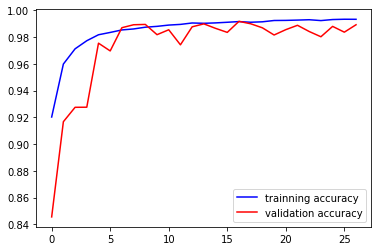

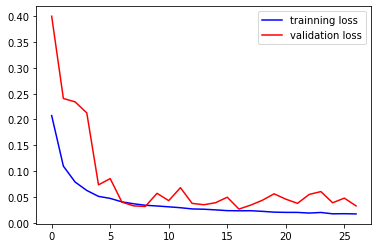

Model Evaluation
Loss: 0.101
Accuracy: 0.966



In [ ]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

(loss,acc) = model2.evaluate(X_test,y_test, verbose=0)
print('Model Evaluation')
print('Loss: %.3f' % loss)
print('Accuracy: %.3f' % acc)
print()